In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr)
library(dplyr)
#library(tidyr)
library(ggplot2)
library(RColorBrewer)

/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/Thea/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


In [3]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/fulltree.tre", parseFunction = parse_taxonomy_greengenes)
#physeq = import_biom("../../SeqData/otu_table.tax.meta.biom")
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [4]:
%%R
head(sample_data(physeq))

Sample Data:        [6 samples by 3 sample variables]:
         Cosm Month        Trtmt
B__        NA    NA        Blank
F_2_15     15   2.0 Ferrihydrite
F_2_28     28   2.0 Ferrihydrite
F_2_33     33   2.0 Ferrihydrite
F_2_9       9   2.0 Ferrihydrite
F_2.5_13   13   2.5 Ferrihydrite


In [5]:
%%R
physeq.noSmall <- subset_samples(physeq,sample_sums(physeq)>=1500)

In [6]:
%%R
mdf = psmelt(physeq)

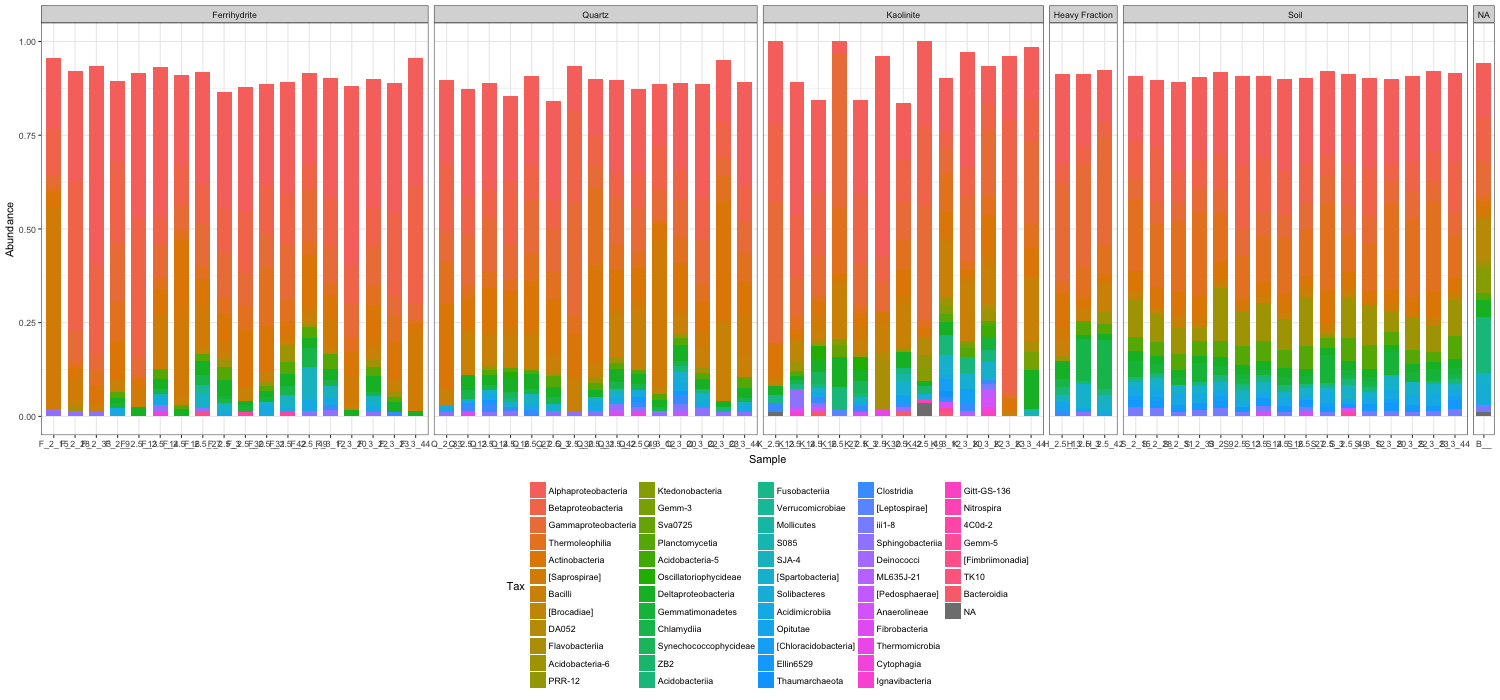

In [21]:
%%R -w 1500 -h 700

cutoff = 0.01
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, Class, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

#p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="bottom")

p

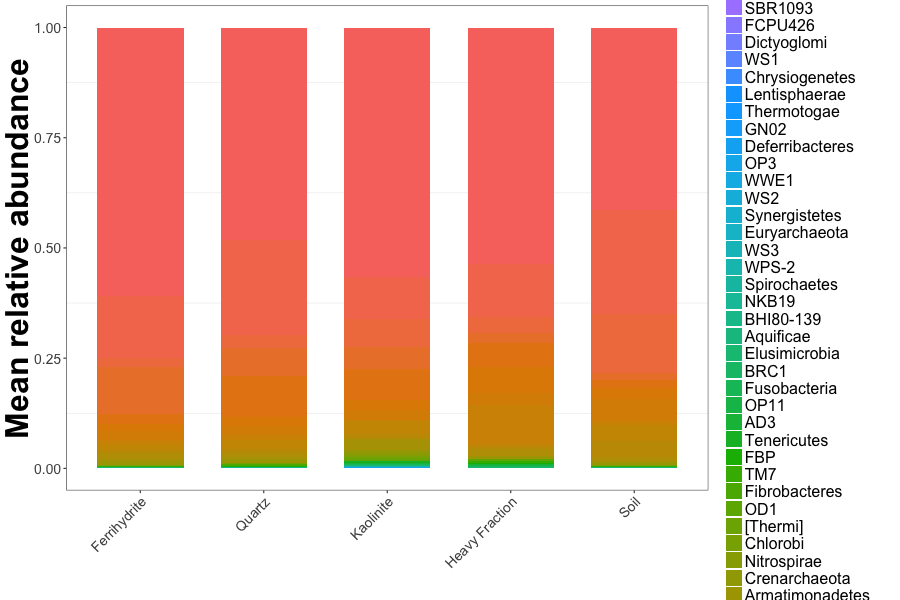

In [23]:
%%R -w 900 -h 600

cutoff = 0.00
totabund = 1500

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, "Unidentified", paste(d.plot$Phylum))
d.plot$Phylum = ifelse(d.plot$Phylum=="unidentified", "Unidentified", paste(d.plot$Phylum))
d.plot = d.plot %>%
    group_by(Trtmt, Phylum, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Phylum) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt) %>%
    group_by(Trtmt,Phylum)%>%
    summarize(Abundance = mean(Abundance))

colnames(d.plot) <- c("Trtmt", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order( Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

N=10
Phyla=factor(d.plot$Tax, d.plot[order(-d.plot$Abundance),]$Tax)[1:N]
#p = p + scale_fill_manual(values = colors, breaks = Phyla)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 1, title = "Phylum", reverse="TRUE"))

#p = p + theme(axis.text.y=theme_text(angle=-90))

p = p + ylab("Mean relative abundance") + xlab("")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(size = 14, angle = 45, hjust=1),
              axis.text.y = element_text(size = 14), 
              axis.title.x = element_text(size = 28),
              axis.title.y = element_text(size = 32,vjust=1,face='bold'),
              legend.title = element_text(size=22),
              legend.text = element_text(size = 16))

p = p + theme(legend.position="right", panel.grid.major= element_blank())

p

In [9]:
%%R
#ggsave(filename="RelabundPhylum16SCombMonths.jpg", p, width=7, height=8.6)

### Making box charts instead of stacked

In [24]:
%%R
d = mdf %>%
    filter(Month!=2.0)%>%
    group_by(Phylum) %>%
    summarize(Abundance = sum(Abundance))
Porder = na.omit(d$Phylum[order(-d$Abundance)])
Porder
# Ordering the phyla roughly in order of total abundance

 [1] Proteobacteria   Actinobacteria   Bacteroidetes    Firmicutes      
 [5] Acidobacteria    Planctomycetes   Verrucomicrobia  Chloroflexi     
 [9] Chlamydiae       TM6              Gemmatimonadetes Armatimonadetes 
[13] Cyanobacteria    Fibrobacteres    Chlorobi         Crenarchaeota   
[17] FBP              Nitrospirae      OD1              TM7             
[21] BRC1             BHI80-139        NKB19            Elusimicrobia   
[25] [Thermi]         WPS-2            Tenericutes      Aquificae       
[29] Fusobacteria     AD3              WS3              OP11            
[33] WS2              Spirochaetes     WWE1             OP3             
[37] Synergistetes    Euryarchaeota    GN02             SR1             
[41] Lentisphaerae    Thermotogae      Deferribacteres  OP8             
[45] Dictyoglomi      FCPU426          NC10             OP1             
[49] WS4              GN04             Chrysiogenetes   [Parvarchaeota] 
[53] SAR406           SBR1093          Caldiserica 

In [108]:
%%R

# Setting up the data so we don't have to re-run each time
Porder = Porder[Porder!="Chlamydiae"]
# Cutting out Chlamydiae b/c it's largely from weird HF sample

cutoff = 0.01
nphyla = 10

Porder = Porder[1:nphyla]
# Selects only the Phyla from the top nphyla (usu. 10)


# For a given sample, I want to make sure that if a phylum from my list is not present,
# we assign it a value of zero. I guess we need to get all the sample IDs

d.plot = mdf %>%
    filter(Month != 2.0)%>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Phylum, Sample) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Phylum %in% Porder)%>%
    arrange(Abundance)

d.plot$Phylum = factor(d.plot$Phylum, levels = Porder)
d.plot = d.plot[with(d.plot, order(d.plot$Phylum)),]
# Changing labels, setting orders, etc.

head(d.plot)

Source: local data frame [6 x 3]
Groups: Phylum [1]

          Phylum   Sample Abundance
          <fctr>    <chr>     <dbl>
1 Proteobacteria   K_3_12 0.2901490
2 Proteobacteria Q_2.5_31 0.3090757
3 Proteobacteria   Q_3_23 0.3213270
4 Proteobacteria   S_3_20 0.3516041
5 Proteobacteria   K_3_22 0.3539192
6 Proteobacteria   S_3_23 0.3663815


In [109]:
%%R
d.plot2 = d.plot %>%
    tidyr::expand(Sample, Phylum)%>%
    left_join(d.plot)
d.plot2[is.na(d.plot2)] = 0
SampTrtmt = unique(mdf[,colnames(mdf)%in% c("Sample","Trtmt")])
d.plot = left_join(d.plot2,SampTrtmt, by="Sample")
d.plot$Trtmt = factor(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

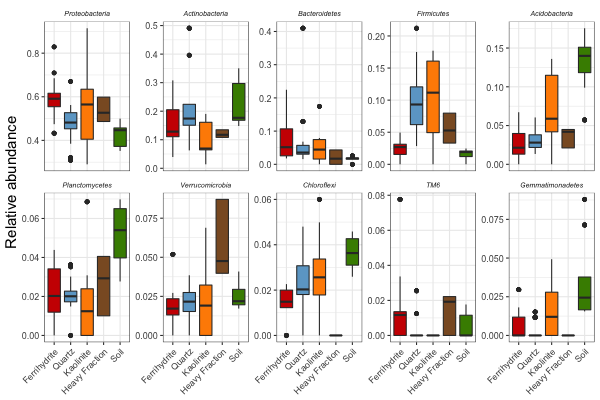

In [110]:
%%R -w 600 -h 400

p = ggplot(d.plot, aes(Trtmt, Abundance, fill = Trtmt))

p = p + geom_boxplot()

p = p + facet_wrap(~Phylum, scales = "free_y",nrow=2)

p = p + scale_fill_manual(values=c("red3","skyblue3","darkorange","tan4","chartreuse4","gold1"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=7, face="italic"), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p

In [105]:
%%R
ggsave(filename="RelabundPhylum16S2MonthsBox.jpg", p, width=7, height=4)

In [107]:
%%R
Phyla = unique(d.plot$Phylum)
Phyla

 [1] Proteobacteria   Actinobacteria   Bacteroidetes    Firmicutes      
 [5] Acidobacteria    Planctomycetes   Verrucomicrobia  Chloroflexi     
 [9] TM6              Gemmatimonadetes
10 Levels: Proteobacteria Actinobacteria Bacteroidetes ... Gemmatimonadetes


In [111]:
%%R
for(i in Phyla){
    a = d.plot%>%
        filter(Phylum==i)
    anova=aov(a$Abundance~a$Trtmt)
    Tukey=TukeyHSD(anova)
    print(i)
    print(summary(anova))
    print(Tukey)}

[1] "Proteobacteria"
             Df Sum Sq Mean Sq F value Pr(>F)    
a$Trtmt       4  1.553  0.3882   42.29 <2e-16 ***
Residuals   426  3.911  0.0092                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = a$Abundance ~ a$Trtmt)

$`a$Trtmt`
                                     diff           lwr         upr     p adj
Quartz-Ferrihydrite         -0.1084394555 -0.1436718534 -0.07320706 0.0000000
Kaolinite-Ferrihydrite      -0.0459430741 -0.0836491286 -0.00823702 0.0081262
Heavy Fraction-Ferrihydrite -0.0465665987 -0.1078216185  0.01468842 0.2295022
Soil-Ferrihydrite           -0.1591637284 -0.1952576813 -0.12306978 0.0000000
Kaolinite-Quartz             0.0624963815  0.0247903269  0.10020244 0.0000714
Heavy Fraction-Quartz        0.0618728568  0.0006178371  0.12312788 0.0463759
Soil-Quartz                 -0.0507242728 -0.0868182257 -0.01463032 0.0012800
Heavy Fr

### Making a plot for Soil Science lecture


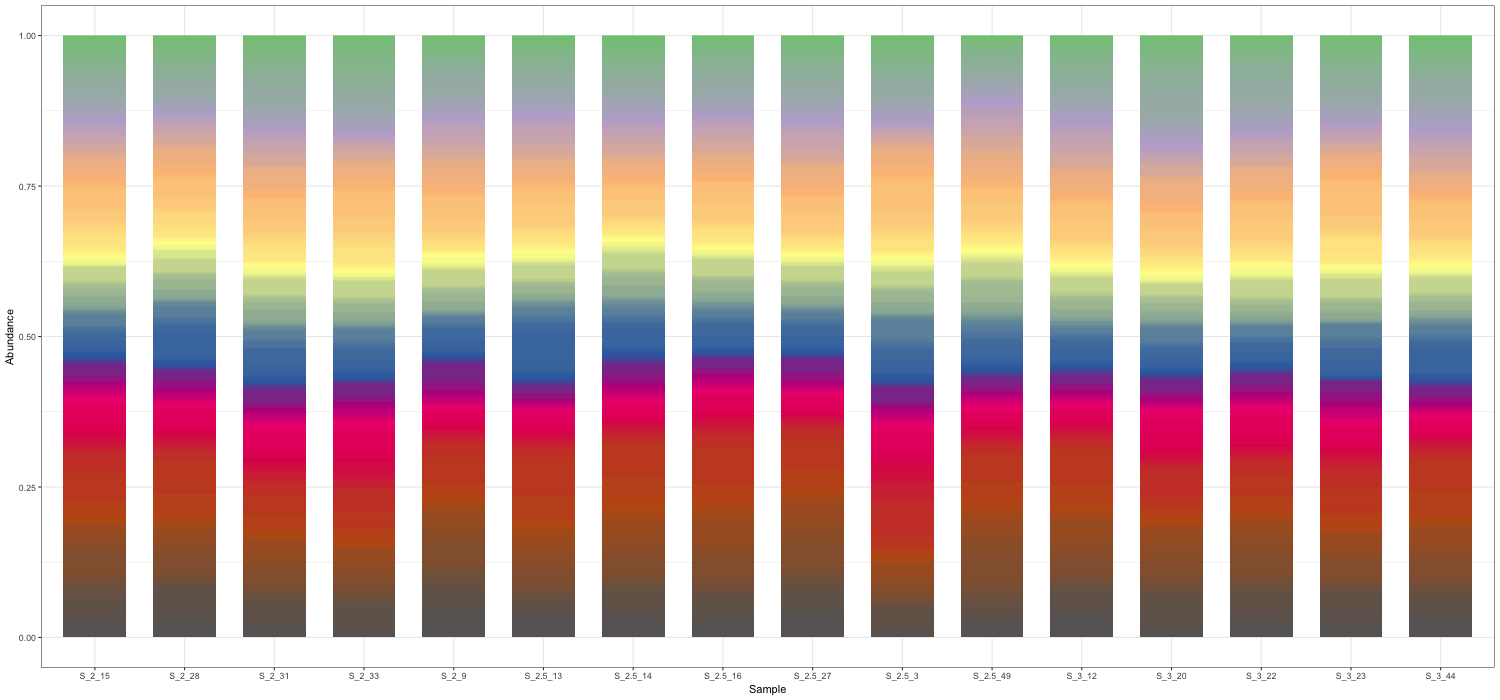

In [12]:
%%R -w 1500 -h 700

cutoff = 0.00001
totabund = 00

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, OTU, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Trtmt == "Soil")%>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Abundance")

#mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
#d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

#d.plot<-d.plot[with(d.plot, order(Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

#scheme <- iwanthue()
#colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

#p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

#p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

colourCount = length(unique(d.plot$Tax))
getPalette = colorRampPalette(brewer.pal(12, "Accent"))

p = p + scale_fill_manual(values = getPalette(colourCount))

#p = p + theme(axis.text.x=theme_text(angle=-90))

p = p + theme_bw()

p = p + theme(legend.position="none")

p

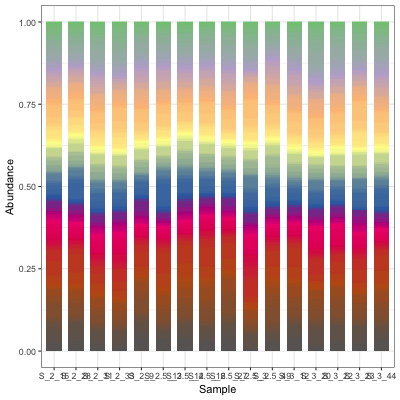

In [16]:
%%R -h 400 -w 400
p

In [17]:
%%R
colourCount

[1] 4872


### What fraction is really Xiphinematobacter?

In [39]:
%%R
Xiphabund = mdf %>%
    filter(Month != 2.0)%>%
    filter(is.na(Trtmt)==FALSE)%>%
    filter(Family == "[Chthoniobacteraceae]")%>%
    group_by(Sample)%>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Genus, Sample, Trtmt) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Genus,-Abundance)

Xiphabund[1:15,]

Source: local data frame [15 x 4]
Groups: Genus, Sample [15]

                          Genus   Sample          Trtmt Abundance
                         <fctr>    <chr>          <chr>     <dbl>
1  Candidatus Xiphinematobacter  H_2.5_3 Heavy Fraction 0.8244937
2  Candidatus Xiphinematobacter F_2.5_27   Ferrihydrite 0.7778656
3  Candidatus Xiphinematobacter H_2.5_42 Heavy Fraction 0.5618729
4  Candidatus Xiphinematobacter H_2.5_13 Heavy Fraction 0.4516129
5  Candidatus Xiphinematobacter F_2.5_13   Ferrihydrite 0.4347826
6  Candidatus Xiphinematobacter F_2.5_42   Ferrihydrite 0.4295302
7  Candidatus Xiphinematobacter   F_3_22   Ferrihydrite 0.4266667
8  Candidatus Xiphinematobacter K_2.5_14      Kaolinite 0.4090909
9  Candidatus Xiphinematobacter F_2.5_14   Ferrihydrite 0.3474747
10 Candidatus Xiphinematobacter F_2.5_49   Ferrihydrite 0.3067797
11 Candidatus Xiphinematobacter F_2.5_30   Ferrihydrite 0.3018868
12 Candidatus Xiphinematobacter  Q_2.5_3         Quartz 0.2831169
13 Candidatus 

In [54]:
%%R
XiphMinAbund = Xiphabund %>%
    filter(Genus=="Candidatus Xiphinematobacter")%>%
    group_by(Trtmt,Abundance)%>%
    group_by(Trtmt)%>%
    summarize(mean(Abundance))
XiphMinAbund

# A tibble: 5 × 2
           Trtmt `mean(Abundance)`
           <chr>             <dbl>
1   Ferrihydrite        0.30123095
2 Heavy Fraction        0.61265985
3      Kaolinite               NaN
4         Quartz        0.14410191
5           Soil        0.06764302


In [73]:
%%R
unique(mdf[mdf$Genus=="Candidatus Xiphinematobacter"&is.na(mdf$Genus)==FALSE,]$OTU)
# All the putative Xiphinematobacter OTUs.

 [1] "13_61"      "65_16235"   "28_1362"    "96_1038"    "83_238674" 
 [6] "99_13508"   "30_40162"   "19_267735"  "37_18735"   "71_2811"   
[11] "73_77659"   "103_143531" "21_779942"  "23_202357"  "55_206194" 
[16] "79_58891"   "80_892437"  "101_78500"  "96_1238295" "99_554788" 
